Importing the necessary libraries:


In [1]:
import pandas as pd
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tabulate import tabulate
from wordcloud import WordCloud
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\costi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\costi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\costi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Setting up the directories

In [2]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_dir = os.path.join(base_dir, "src")
data_dir = os.path.join(base_dir, "data")
rda_2017_dir = os.path.join(data_dir, "rumor-detection-acl-2017")
twitter15_dir = os.path.join(rda_2017_dir, "twitter15")
twitter16_dir = os.path.join(rda_2017_dir, "twitter16")

Creating the dataframe for twitter15:

In [3]:
labels = []
tweet_ids = []
with open(f'{twitter15_dir}/label.txt', 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        label, tweet_id = line.split(':', 1)
        tweet_ids.append(tweet_id)
        labels.append(label)

df_labels = pd.DataFrame({
    'tweet_id': tweet_ids,
    'label': labels
})

tweet_text_ids = []
tweet_texts = []
with open(f'{twitter15_dir}/source_tweets.txt', 'r', encoding='utf-8') as f:
    for line in f:
        if not line:
            continue
        tweet_id, text = line.split('\t', 1)
        tweet_text_ids.append(tweet_id)
        tweet_texts.append(text)

df_tweet = pd.DataFrame({
    'tweet_id': tweet_text_ids,
    'text': tweet_texts
})

df_15 = pd.merge(df_labels, df_tweet, on='tweet_id', how='inner')

print(tabulate(df_15.head(), headers='keys', tablefmt='psql'))

+----+--------------------+------------+------------------------------------------------------------------------------------------------------+
|    |           tweet_id | label      | text                                                                                                 |
|----+--------------------+------------+------------------------------------------------------------------------------------------------------|
|  0 | 731166399389962242 | unverified | 🔥ca kkk grand wizard 🔥 endorses @hillaryclinton #neverhillary #trump2016 URL                       |
|  1 | 714598641827246081 | unverified | an open letter to trump voters from his top strategist-turned-defector URL via @xojanedotcom         |
|  2 | 691809004356501505 | non-rumor  | "america is a nation of second chances" —@potus on new reforms to solitary confinement: URL URL      |
|  3 | 693204708933160960 | non-rumor  | brandon marshall visits and offers advice, support to brother of fallen hero zaevion dobson: URL 

creating the dataframe for twitter16:

In [4]:
labels = []
tweet_ids = []
with open(f'{twitter16_dir}/label.txt', 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        label, tweet_id = line.split(':', 1)
        tweet_ids.append(tweet_id)
        labels.append(label)

df_labels = pd.DataFrame({
    'tweet_id': tweet_ids,
    'label': labels
})

tweet_text_ids = []
tweet_texts = []
with open(f'{twitter16_dir}/source_tweets.txt', 'r', encoding='utf-8') as f:
    for line in f:
        if not line:
            continue
        tweet_id, text = line.split('\t', 1)
        tweet_text_ids.append(tweet_id)
        tweet_texts.append(text)

df_tweet = pd.DataFrame({
    'tweet_id': tweet_text_ids,
    'text': tweet_texts
})

df_16 = pd.merge(df_labels, df_tweet, on='tweet_id', how='inner')

print(tabulate(df_16.head(), headers='keys', tablefmt='psql'))

+----+--------------------+------------+--------------------------------------------------------------------------------------------------+
|    |           tweet_id | label      | text                                                                                             |
|----+--------------------+------------+--------------------------------------------------------------------------------------------------|
|  0 | 656955120626880512 | false      | correct predictions in back to the future ii URL                                                 |
|  1 | 615689290706595840 | true       | .@whitehouse in rainbow colors for #scotusmarriage? here's what i think about that decision: URL |
|  2 | 613404935003217920 | false      | cops bought the alleged church shooter burger king hours after killings URL                      |
|  3 | 731166399389962242 | unverified | 🔥ca kkk grand wizard 🔥 endorses @hillaryclinton #neverhillary #trump2016 URL                   |
|  4 | 714598641827246

Merging the dataframes and removing duplicates:

In [12]:
df_merged = pd.concat([df_15, df_16], ignore_index=True)

print("Duplicates by tweet_id:", df_merged.duplicated(subset='tweet_id').sum())
print("Duplicates by text:", df_merged.duplicated(subset='text').sum())

df_merged = df_merged.drop_duplicates(subset=['tweet_id', 'text'], keep='first').reset_index(drop=True)

print(f"\nRemaining tweets: {len(df_merged)}")

Duplicates by tweet_id: 169
Duplicates by text: 289

Remaining tweets: 2139


Label counts:

In [13]:
label_counts = df_merged['label'].value_counts()
print(tabulate(label_counts.reset_index(), headers=['Label', 'Count'], tablefmt='psql'))

+----+------------+---------+
|    | Label      |   Count |
|----+------------+---------|
|  0 | non-rumor  |     579 |
|  1 | true       |     579 |
|  2 | false      |     575 |
|  3 | unverified |     406 |
+----+------------+---------+


Text count distribution:

In [14]:
df_merged['text_length'] = df_merged['text'].apply(lambda x: len(x.split()))
df_merged['char_length'] = df_merged['text'].apply(len)

print(tabulate(df_merged[['text_length','char_length']].describe(), headers='keys', tablefmt='psql'))

+-------+---------------+---------------+
|       |   text_length |   char_length |
|-------+---------------+---------------|
| count |     2139      |     2139      |
| mean  |       15.3782 |       92.9322 |
| std   |        4.1748 |       23.574  |
| min   |        1      |       10      |
| 25%   |       13      |       78      |
| 50%   |       15      |       95      |
| 75%   |       18      |      111      |
| max   |       29      |      141      |
+-------+---------------+---------------+


Cleaning the text:

In [15]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [57]:
def clean_text(text):
    text = text.lower()

    # text = re.sub(r'[^@#a-z0-9\s]', '', text)
    text = re.sub(r"(?!#)\W", " ", text)
    text = re.sub(r'url', '', text)
    text = re.sub(r"\s+", " ", text).strip()

    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return " ".join(tokens)

In [58]:
df_merged['clean_text'] = df_merged['text'].apply(clean_text)

In [59]:
print(tabulate(df_merged[['text','clean_text']].head(), headers='keys', tablefmt='psql'))

+----+------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------+
|    | text                                                                                                 | clean_text                                                                        |
|----+------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------|
|  0 | 🔥ca kkk grand wizard 🔥 endorses @hillaryclinton #neverhillary #trump2016 URL                       | kkk grand wizard endorses hillaryclinton neverhillary trump2016                   |
|  1 | an open letter to trump voters from his top strategist-turned-defector URL via @xojanedotcom         | open letter trump voter top strategist turned defector via xojanedotcom           |
|  2 | "america is a nation of s

All tweets word cloud:

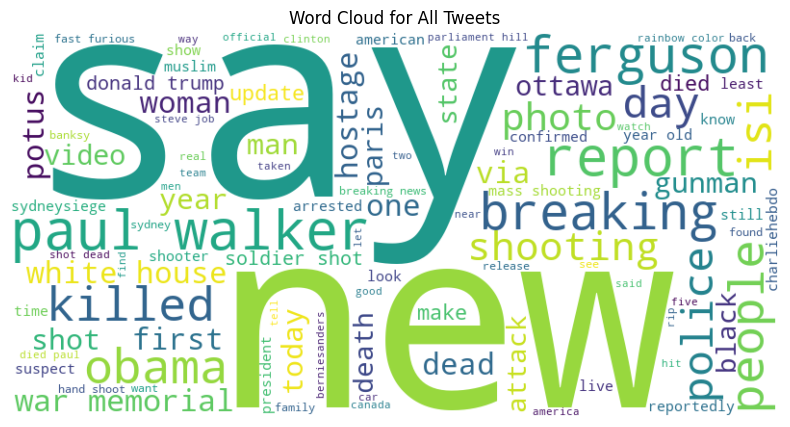

In [60]:
all_text = ' '.join(df_merged['clean_text'].values)

wordcloud = WordCloud(
    width=800, height=400,
    background_color='white',
    max_words=100
).generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for All Tweets')
plt.show()

Word cloud for each label:


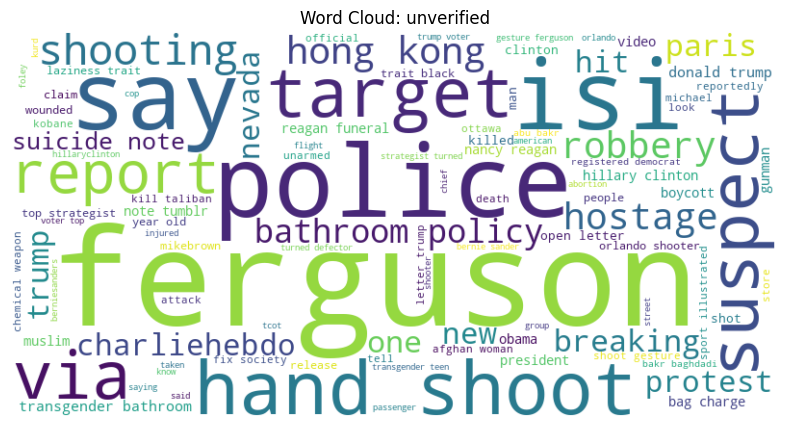

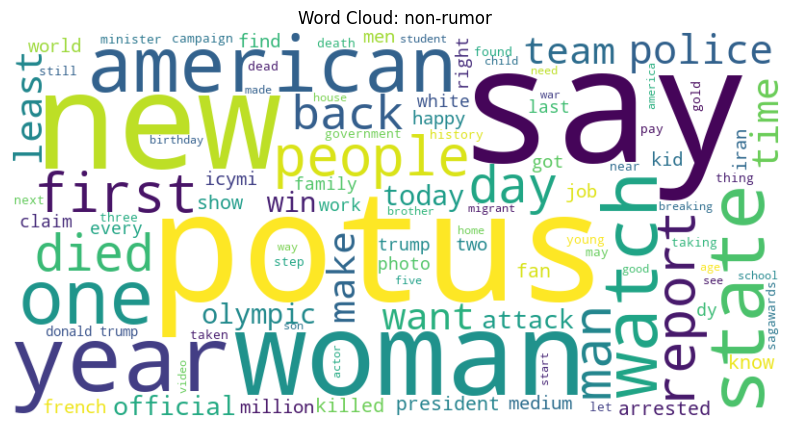

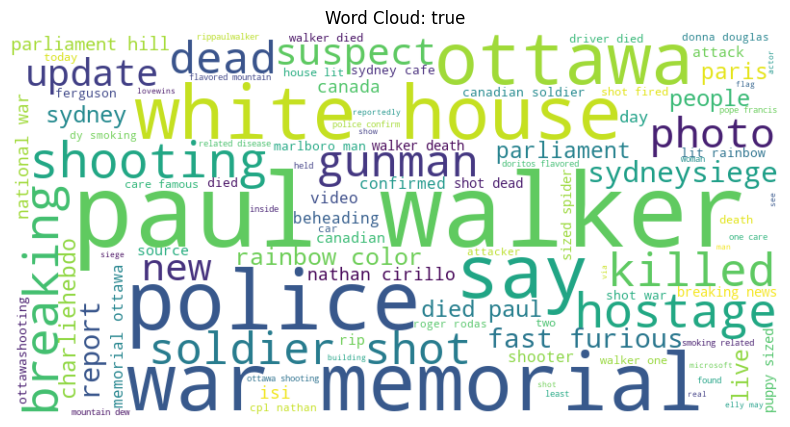

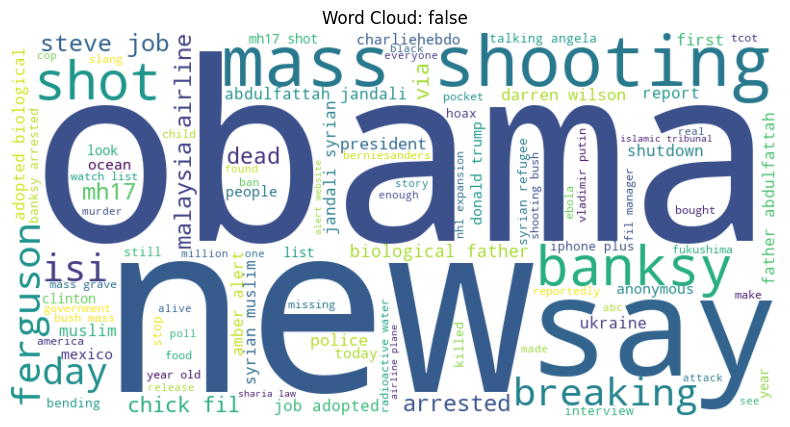

In [61]:
for label_name in df_merged['label'].unique():
    subset = df_merged[df_merged['label'] == label_name]
    label_text = ' '.join(subset['clean_text'].values)

    wc_label = WordCloud(
        width=800, height=400,
        background_color='white',
        max_words=100
    ).generate(label_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc_label, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud: {label_name}')
    plt.show()